In [11]:
from __future__ import print_function

import numpy as np
import os
import argparse
from collections import OrderedDict
import cPickle as pickle

def loadYear(year):
  filename = 'freq/{}-onegram.pkl'.format(year)
  with open(filename, 'r') as f:
    mapping = pickle.load(f)
  return mapping

def kld(dist1, dist2):
  dist1 += 1e-16
  return np.sum(dist1 * (np.log(dist1) - np.log(dist2)))

def jsd(dist1, dist2):
  m = 0.5 * (dist1 + dist2)
  return 0.5 * (kld(dist1, m) + kld(dist2, m))

Load the pre-trained vectors

In [2]:
years = [1900 + x for x in range(101)]

models = OrderedDict()
for year in years:
    models[year] = loadYear(year)
    print("year {}: {} tokens".format(year, len(models[year])))


year 1900: 121241 tokens
year 1901: 131250 tokens
year 1902: 115357 tokens
year 1903: 122998 tokens
year 1904: 124870 tokens
year 1905: 121503 tokens
year 1906: 122688 tokens
year 1907: 117704 tokens
year 1908: 115159 tokens
year 1909: 108476 tokens
year 1910: 124807 tokens
year 1911: 120063 tokens
year 1912: 113984 tokens
year 1913: 102461 tokens
year 1914: 100219 tokens
year 1915: 86833 tokens
year 1916: 101896 tokens
year 1917: 100694 tokens
year 1918: 90346 tokens
year 1919: 93861 tokens
year 1920: 108284 tokens
year 1921: 98210 tokens
year 1922: 105297 tokens
year 1923: 107166 tokens
year 1924: 96436 tokens
year 1925: 107698 tokens
year 1926: 99515 tokens
year 1927: 103309 tokens
year 1928: 101431 tokens
year 1929: 104709 tokens
year 1930: 96960 tokens
year 1931: 93703 tokens
year 1932: 93536 tokens
year 1933: 91264 tokens
year 1934: 87426 tokens
year 1935: 91842 tokens
year 1936: 89236 tokens
year 1937: 98387 tokens
year 1938: 92640 tokens
year 1939: 84280 tokens
year 1940: 87304

Compute the distribution on token frequencies

In [3]:
tokens = models[years[0]].keys()
# extract common vocab from two embeddings
for year in years:
    tokens_tmp = models[year].keys()
    tokens = list(set(tokens).intersection(tokens_tmp))
subsample = len(tokens)
if subsample:
  tokens = np.random.choice(tokens, size = subsample, replace=False)
print(len(tokens))


39312


In [13]:
freqs = {}
for year in years:
    freqs[year] = []
    for token in tokens:
        freqs[year].append(models[year][token])
    freqs[year] = np.array(freqs[year], dtype=float)
    freqs[year] /= np.sum(freqs[year])

# del models
print("{} tokens to be compared".format(len(freqs[years[0]])))

39312 tokens to be compared


Now, consider the PIP loss between embeddings between different years. Depending on the size, 
we use two solutions. It depends on if the PIP matrices are small enough to fit in memory.

In [14]:
jsd_losses = np.zeros((len(years), len(years)))

for idx1, year1 in enumerate(years):
    for idx2, year2 in enumerate(years):
        jsd_diff = jsd(freqs[year1], freqs[year2])
        jsd_losses[idx1, idx2] = jsd_diff


Now we visualize the result. 

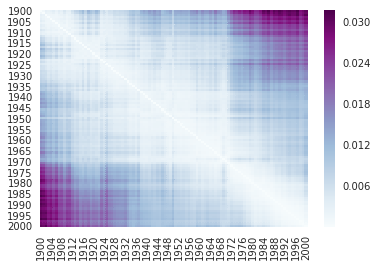

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

np.save('jsd_matrix.npy', jsd_losses)
dimensions = range(jsd_losses.shape[0])
ixgrid = np.ix_(dimensions, dimensions)
real_dimension = years
plt.figure()
df = pd.DataFrame(jsd_losses[ixgrid], index=real_dimension, columns=real_dimension)
ax = sns.heatmap(df, cmap="BuPu")#, xticklabels=len(dimensions)-1, yticklabels=len(dimensions)-1)
fig = ax.get_figure()
fig.savefig("jsd.pdf")


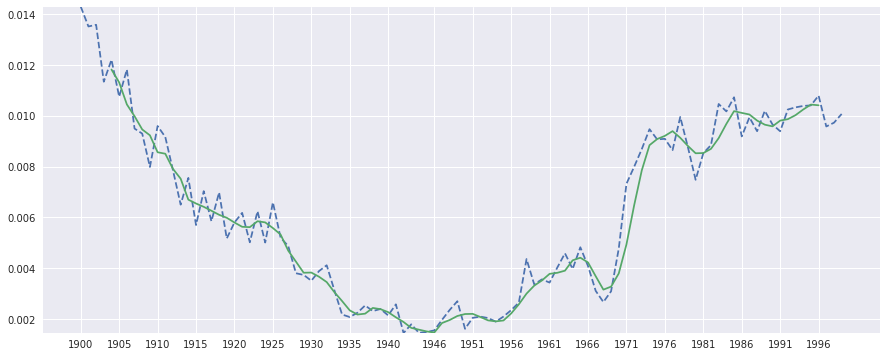

In [22]:
plt.close()
plt.clf()
labels = list(years)
year = 1944
tmp_labels = list(labels)
lines = jsd_losses[year - labels[0]].tolist()
lines.pop(year - labels[0])
tmp_labels.pop(year - labels[0])
tmp_dimensions = list(dimensions)
tmp_dimensions.pop(year - labels[0])
width = 5
if width == 1:
    kernel = np.array([1])
elif width == 3:
    kernel = (1.0/35) * np.array([-3, 12, 17, 12, -3])
elif width == 4:
    kernel = (1.0/21) * np.array([-2, 3, 6, 7, 6, 3, -2])
elif width == 5:
    kernel = (1.0/231) * np.array([-21, 14, 39, 54, 59, 54, 39, 14, -21])
ma = np.convolve(lines, kernel, mode='valid')

ymin = sorted(lines)[1]
ymax = sorted(lines)[-1]
plt.figure(num=None, figsize=(15, 6), facecolor='w', edgecolor='k')
plt.plot(lines, '--')
plt.plot(tmp_dimensions[width-1:-width+1], ma)
per = 5
plt.xticks([tmp_dimensions[per*i] for i in range(len(tmp_dimensions) / per)], [tmp_labels[per*i] for i in range(len(tmp_dimensions) / per)])
plt.ylim((ymin, ymax))
plt.savefig("jsd_loss_{}.pdf".format(year))
